In [557]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import MySQLdb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.discrete.discrete_model import Logit, MNLogit
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import statsmodels.api as st
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)

In [558]:
# import data
# feature engineering?
# k fold
# hyperparameter tuning
# Hospital Insurance -> classification
# Hospital Utilisation -> classification
# performance measure
# !pip install lxml

In [559]:
# # DB Connection
# myvars = {}
# with open("risaac-mysql-password") as myfile:
#     for line in myfile:
#         name, var = line.partition(":")[::2]
#         myvars[name.strip()] = var.strip()
        
# myvars['DB databasename'] = 'I501saptpurkFall22grp_06_db'

# conn = MySQLdb.connect(host="localhost", user=myvars['DB username'], passwd=myvars['DB password'], db=myvars['DB databasename'])
# cursor = conn.cursor()

In [560]:
# df = pd.read_sql('select * from P_DEMO_HUQ_HIQ', conn)
df = pd.read_csv("P_DEMO_HUQ_HIQ.csv")

In [561]:
# remove INDFMPIR and replace with INDFMPIR_imputed
df = df.drop("INDFMPIR", axis = 1)
df = df[~df.isna().any(axis = 1)]
df = df.rename(columns = {"INDFMPIR_imputed":"INDFMPIR"})

# copy dataframe
df_temp = df.copy()

In [562]:
# segragating features into nominal, ordinal and numeric
nominal_cols = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
    ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
    ,"HUQ051"
]

numeric_cols = [
    "RIDAGEYR"
    ,"RIDAGEMN"
    ,"INDFMPIR"
]

In [563]:
nominal_cols_wo_Target = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
#     ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

In [564]:
# columns to one hot encode
# RIDRETH3
# RIDRETH1
# DMDBORN4 - Encode to 0,1
# DMDMARTZ
# RIDEXPRG
# SIALANG - Encode to 0,1
# SIAPROXY - Encode to 0,1
# SIAINTRP - Encode to 0,1

# HUQ030
# HUQ071 - Encode to 0,1
# HUQ090 - Encode to 0,1
# HIQ011 - Encode to 0,1
# HIQ032A - Encode to 0,1

# HIQ270
# HIQ210

In [565]:
# covert 1=>0, 2=>1
enc_1_0_cols = ["DMDBORN4"
               ,"SIALANG"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 0, 1)
    
# covert 1=>1, 2=>0
enc_1_0_cols = ["SIAPROXY"
               ,"SIAINTRP"
               ,"HUQ071"
               ,"HUQ090"
               ,"HIQ011"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 1, 0)


In [566]:
one_hot_enc_cols = ["RIDRETH3"
                   ,"RIDRETH1"
                   ,"DMDMARTZ"
                   ,"RIDEXPRG"
                   ,"HUQ030"
#                    ,"HIQ270"
#                    ,"HIQ210"
                   ]

In [567]:
df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]] = df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]].astype("Int32")

In [568]:
demo_cols = [
    "RIAGENDR"
    ,"RIDAGEMN"
    ,"RIDRETH1"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"DMDYRUSZ"
    ,"DMDEDUC2"
    ,"INDFMPIR"
]

huq_cols = ["HUQ010"
           ,"HUQ071"
           ,"HUQ090"
           ,"HUQ051"]

hiq_cols = ["HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210']

### Hospital Utilisation Prediction Using Demographics & Health Insurance

In [569]:
target_col = "HIQ011"

In [570]:
df_dum = pd.get_dummies(df[demo_cols + huq_cols + [target_col]], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols], drop_first = True)

In [571]:
df_dum = st.add_constant(df_dum, prepend = False)

In [572]:
X_train, X_test, y_train, y_test = train_test_split(df_dum[df_dum.columns[df_dum.columns != target_col]], 
                                                    df_dum[target_col], 
                                                    test_size=0.20
                                                    )

In [573]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [574]:
y_train = y_train.astype(int)

In [575]:
sm = SMOTE()

In [576]:
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

In [577]:
# based on statsmodel multinomial logit
mdl = st.Logit(y_train, X_train)
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.496410
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 HIQ011   No. Observations:                21242
Model:                          Logit   Df Residuals:                    21217
Method:                           MLE   Df Model:                           24
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                  0.2838
Time:                        20:36:14   Log-Likelihood:                -10545.
converged:                       True   LL-Null:                       -14724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RIAGENDR       0.0043      0.042      0.102      0.919      -0.078       0.087
RIDAGEMN       0.0039      0.

In [578]:
# filter significant columns based on p value
out = mdl_fit.summary()
out = out.tables[1].as_html()
out = pd.read_html(out, header=0, index_col=0)[0]
new_cols = out[out["P>|z|"] <= 0.1].index.tolist()

In [579]:
mdl = st.Logit(y_train, X_train[new_cols])
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.501619
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 HIQ011   No. Observations:                21242
Model:                          Logit   Df Residuals:                    21227
Method:                           MLE   Df Model:                           14
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                  0.2763
Time:                        20:36:14   Log-Likelihood:                -10655.
converged:                       True   LL-Null:                       -14724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RIDAGEMN       0.0039      0.000     27.055      0.000       0.004       0.004
DMDBORN4       0.9993      0.

In [580]:
model = LogisticRegression()

In [581]:
grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4)

In [582]:
y_train = y_train.astype("float")

In [583]:
grid_lr.fit(X_train[new_cols], y_train)

/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=4,
             param_grid={'C': [0.01, 0.1], 'max_iter': [100, 150, 200, 300],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'saga']},
             return_train_score=True, scoring='f1')

In [584]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.099279      0.005155         0.004284        0.000114    0.01   
1        0.073226      0.003240         0.003306        0.000657    0.01   
2        0.280283      0.043593         0.003804        0.000664    0.01   
3        0.077400      0.005544         0.002626        0.000073    0.01   
4        0.093805      0.008051         0.003700        0.000648    0.01   
5        0.335913      0.025995         0.003880        0.000668    0.01   
6        0.072888      0.001832         0.002412        0.000021    0.01   
7        0.134759      0.007214         0.003687        0.000650    0.01   
8        0.451732      0.013371         0.003699        0.000662    0.01   
9        0.077637      0.008635         0.002448        0.000091    0.01   
10       0.193934      0.007793         0.003649        0.000744    0.01   
11       0.719985      0.131302         0.003251        0.000454    0.01   
12       0.088536      0.004883         0.002397        0.000052     0.1   
13       0.055270      0.001572         0.002451        0.000024     0.1   
14       0.229855      0.022216         0.003773        0.000779     0.1   
15       0.106189      0.009829         0.003693        0.000643     0.1   
16       0.102702      0.001922         0.003694        0.000621     0.1   
17       0.361909      0.055518         0.004085        0.000075     0.1   
18       0.089091      0.005453         0.002499        0.000083     0.1   
19       0.136732      0.003483         0.004070        0.000049     0.1   
20       0.424124      0.002742         0.004111        0.000059     0.1   
21       0.096626      0.002403         0.002891        0.000704     0.1   
22       0.197227      0.006602         0.003672        0.000531     0.1   
23       0.628966      0.031820         0.003974        0.000162     0.1   

   param_max_iter param_penalty param_solver  \
0             100            l2    newton-cg   
1             100            l2        lbfgs   
2             100            l2         saga   
3             150            l2    newton-cg   
4             150            l2        lbfgs   
5             150            l2         saga   
6             200            l2    newton-cg   
7             200            l2        lbfgs   
8             200            l2         saga   
9             300            l2    newton-cg   
10            300            l2        lbfgs   
11            300            l2         saga   
12            100            l2    newton-cg   
13            100            l2        lbfgs   
14            100            l2         saga   
15            150            l2    newton-cg   
16            150            l2        lbfgs   
17            150            l2         saga   
18            200            l2    newton-cg   
19            200            l2        lbfgs   
20            200            l2         saga   
21            300            l2    newton-cg   
22            300            l2        lbfgs   
23            300            l2         saga   

                                               params  split0_test_score  \
0   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.748600   
1   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.738608   
2   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.725965   
3   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.748600   
4   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.739489   
5   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.724815   
6   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.748600   
7   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.738475   
8   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.722013   
9   {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.748600   
10  {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.

In [585]:
grid_lr.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [586]:
y_pred = grid_lr.predict(X_test[new_cols])
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

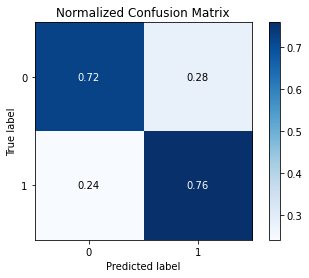

In [587]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [588]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.30      0.72      0.43       379
         Yes       0.95      0.76      0.84      2621

    accuracy                           0.75      3000
   macro avg       0.63      0.74      0.64      3000
weighted avg       0.87      0.75      0.79      3000



In [589]:
y_pred = grid_lr.predict_proba(X_test[new_cols])

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

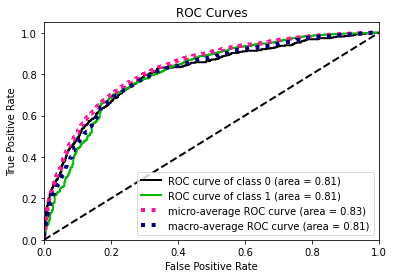

In [590]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [340]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.504498, G-mean=0.733


In [341]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

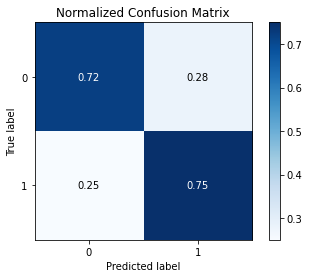

In [342]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [343]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.26      0.72      0.39       335
         Yes       0.95      0.75      0.84      2665

    accuracy                           0.75      3000
   macro avg       0.61      0.73      0.61      3000
weighted avg       0.88      0.75      0.79      3000



In [358]:
y_pred = grid_lr.predict_proba(X_test[new_cols])
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

#Calculate f-Score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest g-mean
ix = np.argmax(fscore)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.067601, G-mean=0.945


In [359]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

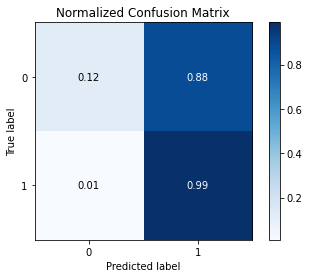

In [360]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [361]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.74      0.12      0.21       335
         Yes       0.90      0.99      0.94      2665

    accuracy                           0.90      3000
   macro avg       0.82      0.56      0.58      3000
weighted avg       0.88      0.90      0.86      3000



### SVM Classifier

In [ ]:
model = SVC()

In [ ]:
grid_vals = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'sigmoid', 'poly'],
            'degree':[2,3,4]} 

In [ ]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [ ]:
grid_lr.fit(X_train, y_train)

In [382]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.960946      0.002264         0.040743        0.000628   
1         1.099327      0.135029         0.043597        0.006494   
2         1.394585      0.068938         0.057510        0.000105   
3         0.660864      0.004650         0.029808        0.000322   
4         0.886199      0.003487         0.039121        0.000232   
..             ...           ...              ...             ...   
427       3.572565      0.232276         0.065551        0.000831   
428       5.119629      0.005278         0.097707        0.001089   
429       2.568057      0.018876         0.050430        0.000757   
430       3.417277      0.010357         0.065267        0.000408   
431       5.124807      0.038446         0.099197        0.001714   

    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0              gini               2               0.85                      1   
1              gini               2               0.85                      1   
2              gini               2               0.85                      1   
3              gini               2               0.85                      1   
4              gini               2               0.85                      1   
..              ...             ...                ...                    ...   
427        log_loss               8               0.95                      2   
428        log_loss               8               0.95                      2   
429        log_loss               8               0.95                      2   
430        log_loss               8               0.95                      2   
431        log_loss               8               0.95                      2   

    param_min_samples_split param_n_estimators  \
0                         2                150   
1                         2                200   
2                         2                300   
3                         4                150   
4                         4                200   
..                      ...                ...   
427                       2                200   
428                       2                300   
429                       4                150   
430                       4                200   
431                       4                300   

                                                params  split0_test_score  \
0    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.315644   
1    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.317681   
2    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.316159   
3    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.317482   
4    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.316995   
..                                                 ...                ...   
427  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.445594   
428  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.437969   
429  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.437909   
430  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.444632   
431  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.438219   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.329295           0.312807         0.319249        0.007197   
1             0.328559           0.310454         0.318898        0.007441   
2             0.322420           0.312800         0.317127        0.003986   
3             0.316287           0.313673         0.315814        0.001590   
4             0.322886           0.310445         0.316775        0.005081   
..                 ...                ...              ...             ...   
427           0.450160           0.433143         0.442966        0.007191   
428           0.441077           0.435292         0.4

In [383]:
grid_lr.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.95,
                       min_samples_split=4, n_estimators=200)

In [384]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

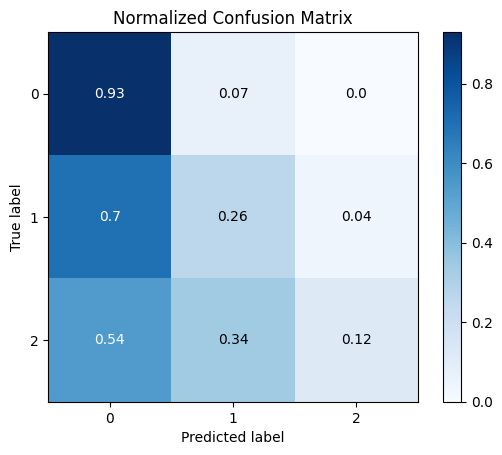

In [385]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [386]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

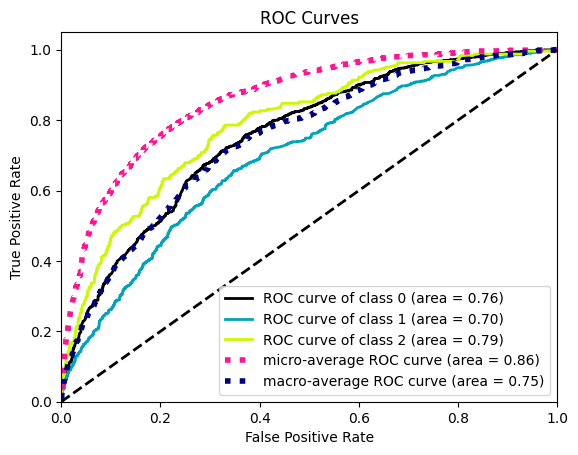

In [387]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### XGBoost

In [472]:
model = XGBClassifier()
grid_vals = {"n_estimators":[400,500,600], "learning_rate" : [0.1, 0.01], "max_depth" : [2,3,4], "subsample":[0.7, 0.8],
                      "colsample_bytree":[0.7,0.8], 'reg_alpha':[1e-5, 1e-2]}

In [473]:
# grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='roc_auc', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=16) 

In [474]:
# undersampling
# cc = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [475]:
grid_lr.fit(X_train, y_train)
# grid_lr.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=16,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 3, 4],
                         'n_estimators': [400, 500, 600],
                         'reg_alpha': [1e-05, 0.01], 'subsample': [0.7, 0.8]},
             return_train_score=True, scoring='roc_auc')

In [476]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         6.953051      0.173524         0.059162        0.007727   
1         7.058244      0.556499         0.061095        0.009567   
2         7.180534      0.153662         0.048142        0.008565   
3         7.410647      0.303663         0.048353        0.002907   
4         8.981220      0.465303         0.069991        0.015998   
5         8.769277      0.156271         0.067349        0.014643   
6         8.020005      0.332311         0.060623        0.013274   
7         9.232752      0.656653         0.060316        0.006273   
8        11.196490      0.447049         0.074851        0.015611   
9        10.746786      0.857746         0.093007        0.004423   
10       10.617825      0.406552         0.061058        0.001759   
11       10.202542      0.202133         0.076540        0.009973   
12       10.180544      0.572795         0.067530        0.013519   
13       10.431144      0.307164         0.076903        0.010180   
14       10.896143      0.181172         0.093150        0.015227   
15       10.157627      0.298674         0.100217        0.021136   
16       12.275818      0.397371         0.100738        0.030428   
17       12.163604      0.293827         0.105499        0.011072   
18       12.705953      0.348569         0.076859        0.005269   
19       12.348138      0.207842         0.112585        0.014365   
20       15.354594      0.464741         0.094649        0.015157   
21       14.739270      0.748481         0.113538        0.018643   
22       15.001092      0.714939         0.124627        0.011354   
23       14.177163      0.210674         0.084350        0.006766   
24       12.658124      0.085104         0.114970        0.001453   
25       12.934135      0.629276         0.104448        0.025218   
26       13.680305      0.447140         0.121435        0.019834   
27       12.521598      0.021217         0.103463        0.028287   
28       16.477398      0.553575         0.133762        0.002494   
29       16.659323      0.320811         0.162535        0.013232   
30       17.029337      1.098997         0.139952        0.023589   
31       15.948874      0.754004         0.113970        0.013207   
32       19.440777      0.072216         0.167894        0.003888   
33       18.945247      0.253188         0.108052        0.034633   
34       19.520839      0.688064         0.145895        0.024199   
35       19.460819      1.031683         0.161815        0.021816   
36        7.325345      0.467115         0.052973        0.003193   
37        7.347126      0.271043         0.056776        0.013082   
38        6.751641      0.810539         0.060722        0.015015   
39        6.514925      0.294953         0.048356        0.002913   
40        9.225203      0.329299         0.057156        0.008416   
41        8.983378      0.386433         0.076383        0.014395   
42        8.551960      0.219982         0.058246        0.012411   
43        9.160630      0.066541         0.068874        0.008227   
44        9.146217      0.653712         0.065576        0.027560   
45       10.520137      0.940535         0.066965        0.011609   
46       10.746164      0.587568         0.101987        0.002168   
47       10.634199      0.815650         0.076197        0.017154   
48        9.762777      1.104941         0.066248        0.002207   
49       10.748743      0.251250         0.083265        0.011641   
50       10.334718      0.831980         0.078613        0.007064   
51        9.461605      0.180699         0.082635        0.016233   
52       12.533398      0.595716         0.077969        0.003462   
53       12.827228      0.352498         0.086721        0.008558   
54       12.881785      0.683222         0.078078        0.011960   
55       12.545102      0.692635         0.074880        0.003150   
56       14.937818      1.414945         0.113188        0.016567   
57 

In [477]:
grid_lr.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [478]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

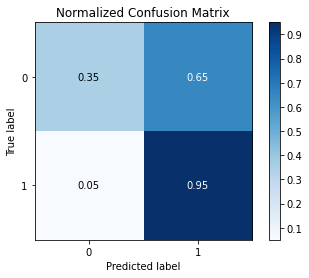

In [479]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [480]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.49      0.35      0.41       345
         Yes       0.92      0.95      0.94      2655

    accuracy                           0.88      3000
   macro avg       0.71      0.65      0.67      3000
weighted avg       0.87      0.88      0.88      3000



In [481]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

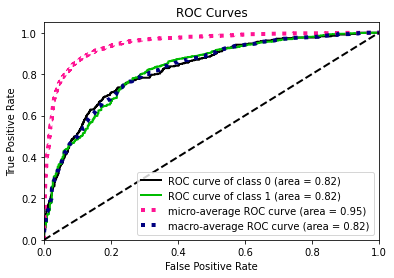

In [482]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [483]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.792233, G-mean=0.757


In [484]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

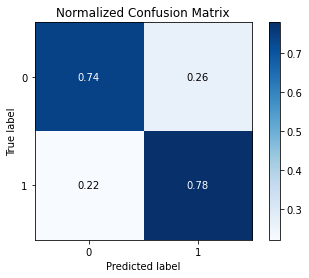

In [485]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [486]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.30      0.74      0.43       345
         Yes       0.96      0.78      0.86      2655

    accuracy                           0.77      3000
   macro avg       0.63      0.76      0.64      3000
weighted avg       0.88      0.77      0.81      3000



Text(0, 0.5, 'Features')

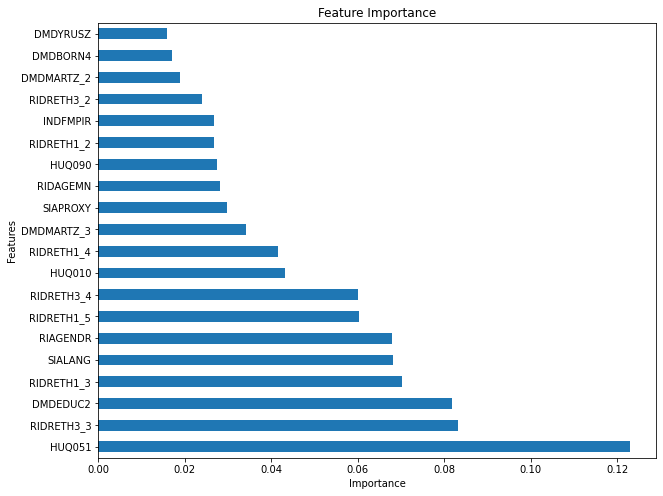

In [498]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### LightGBM

In [499]:
model = LGBMClassifier()

In [500]:
grid_vals = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200, 300],
               'num_leaves': [6, 12, 16,24], 'boosting_type': ['gbdt', 'dart'], 
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1e-5, 1e-2],
               'reg_lambda': [1e-5, 1e-2]}

In [501]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [502]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [6, 12, 16, 24],
                         'reg_alpha': [1e-05, 0.01],
                         'reg_lambda': [1e-05, 0.01],
                         'subsample': [0.7, 0.75]},
             return_train_score=True, scoring='f1_micro')

In [503]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.082643      0.002565         0.008504        0.000128   
1          0.080982      0.001145         0.008859        0.000562   
2          0.081424      0.000454         0.009054        0.000387   
3          0.085393      0.005710         0.009189        0.000543   
4          0.080380      0.003111         0.009007        0.000317   
...             ...           ...              ...             ...   
1147       1.507796      0.052488         0.044833        0.002450   
1148       1.502125      0.035268         0.047667        0.000154   
1149       1.504662      0.046297         0.046422        0.001817   
1150       1.499428      0.044273         0.044858        0.002989   
1151       1.503252      0.048088         0.039411        0.004154   

     param_boosting_type param_colsample_bytree param_learning_rate  \
0                   gbdt                   0.65                0.01   
1                   gbdt                   0.65                0.01   
2                   gbdt                   0.65                0.01   
3                   gbdt                   0.65                0.01   
4                   gbdt                   0.65                0.01   
...                  ...                    ...                 ...   
1147                dart                    0.8                 0.1   
1148                dart                    0.8                 0.1   
1149                dart                    0.8                 0.1   
1150                dart                    0.8                 0.1   
1151                dart                    0.8                 0.1   

     param_n_estimators param_num_leaves param_reg_alpha param_reg_lambda  \
0                   100                6         0.00001          0.00001   
1                   100                6         0.00001          0.00001   
2                   100                6         0.00001             0.01   
3                   100                6         0.00001             0.01   
4                   100                6            0.01          0.00001   
...                 ...              ...             ...              ...   
1147                300               24         0.00001             0.01   
1148                300               24            0.01          0.00001   
1149                300               24            0.01          0.00001   
1150                300               24            0.01             0.01   
1151                300               24            0.01             0.01   

     param_subsample                                             params  \
0                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
1               0.75  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
2                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
3               0.75  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
4                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
...              ...                                                ...   
1147            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   
1148             0.7  {'boosting_type': 'dart', 'colsample_bytree': ...   
1149            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   
1150             0.7  {'boosting_type': 'dart', 'colsample_bytree': ...   
1151            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   

      split0_test_score  split1_test_score  split2_test_score  \
0              0.806602           0.870785           0.866534   
1              0.806602           0.870785           0.866534   
2              0.806602           0.870785           0.866534   
3              0.806602           0.870785           0.866534   
4              0.806602           0.870785           0.866534   
...                 ...                ...                ...   
1147           0.802635        

In [504]:
grid_lr.best_estimator_

LGBMClassifier(colsample_bytree=0.8, n_estimators=300, num_leaves=24,
               reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.7)

In [505]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

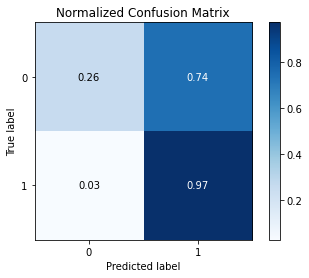

In [506]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [507]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

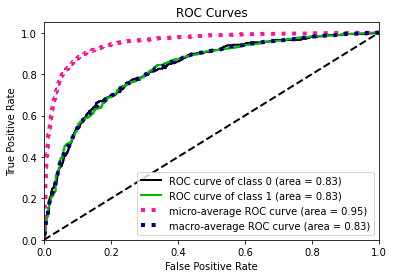

In [508]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [509]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.909285, G-mean=0.756


In [510]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

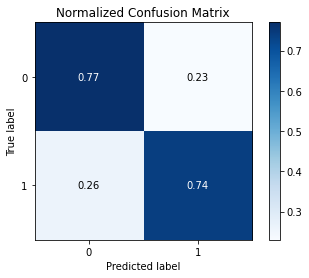

In [511]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [512]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.28      0.77      0.41       345
         Yes       0.96      0.74      0.84      2655

    accuracy                           0.74      3000
   macro avg       0.62      0.76      0.62      3000
weighted avg       0.88      0.74      0.79      3000



Text(0, 0.5, 'Features')

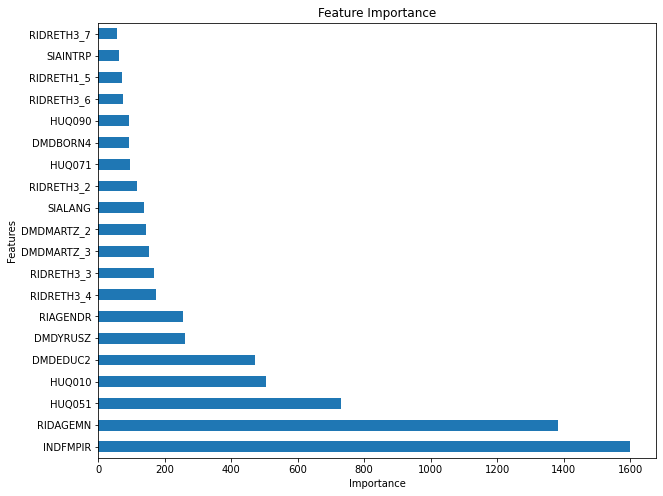

In [513]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### Random Forest Classifier

In [514]:
model = RandomForestClassifier()

In [515]:
grid_vals = {'n_estimators': [150, 200, 300],
             'criterion':['gini', 'entropy', 'log_loss'], 'max_depth': [2,4,6,8],
             'min_samples_split':[2,4], 'min_samples_leaf':[1,2],
             'max_features':[0.85,0.9,0.95]}

In [516]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [517]:
y_train = y_train.astype(int)

In [518]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=RandomForestClassifier(),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': [0.85, 0.9, 0.95],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [150, 200, 300]},
             return_train_score=True, scoring='f1_micro')

In [519]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.079810      0.045136         0.042868        0.000075   
1         1.424170      0.067274         0.056222        0.000410   
2         2.144497      0.106444         0.083007        0.000448   
3         1.071519      0.047637         0.042675        0.000214   
4         1.426393      0.067636         0.055906        0.000296   
..             ...           ...              ...             ...   
427       5.170566      0.123662         0.085455        0.001478   
428       7.158144      0.311571         0.126708        0.001887   
429       3.487387      0.047504         0.064618        0.000747   
430       4.671998      0.044869         0.085340        0.001277   
431       7.563576      0.326239         0.140151        0.011374   

    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0              gini               2               0.85                      1   
1              gini               2               0.85                      1   
2              gini               2               0.85                      1   
3              gini               2               0.85                      1   
4              gini               2               0.85                      1   
..              ...             ...                ...                    ...   
427        log_loss               8               0.95                      2   
428        log_loss               8               0.95                      2   
429        log_loss               8               0.95                      2   
430        log_loss               8               0.95                      2   
431        log_loss               8               0.95                      2   

    param_min_samples_split param_n_estimators  \
0                         2                150   
1                         2                200   
2                         2                300   
3                         4                150   
4                         4                200   
..                      ...                ...   
427                       2                200   
428                       2                300   
429                       4                150   
430                       4                200   
431                       4                300   

                                                params  split0_test_score  \
0    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.741286   
1    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.741286   
2    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.741286   
3    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.741286   
4    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.741286   
..                                                 ...                ...   
427  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.824596   
428  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.824313   
429  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.820912   
430  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.824738   
431  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.825305   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.766648           0.776707         0.761547        0.014903   
1             0.766648           0.766223         0.758052        0.011857   
2             0.766648           0.778549         0.762161        0.015540   
3             0.766648           0.766223         0.758052        0.011857   
4             0.766648           0.779258         0.762397        0.015790   
..                 ...                ...              ...             ...   
427           0.922358           0.932842         0.893265        0.048745   
428           0.922358           0.933834         0.8

In [520]:
grid_lr.best_estimator_

RandomForestClassifier(max_depth=8, max_features=0.85, min_samples_leaf=2,
                       n_estimators=200)

In [521]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

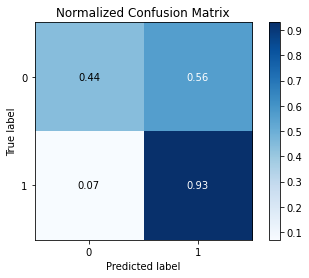

In [522]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [523]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.43      0.44      0.43       345
         Yes       0.93      0.93      0.93      2655

    accuracy                           0.87      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.87      0.87      0.87      3000



In [524]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

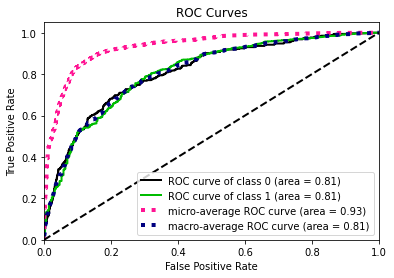

In [525]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [526]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.712818, G-mean=0.742


In [527]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

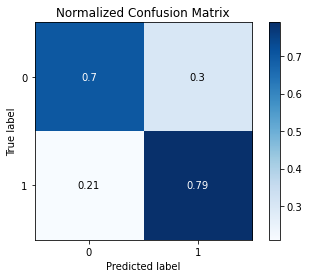

In [528]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [529]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.30      0.70      0.42       345
         Yes       0.95      0.79      0.86      2655

    accuracy                           0.78      3000
   macro avg       0.63      0.74      0.64      3000
weighted avg       0.88      0.78      0.81      3000



Text(0, 0.5, 'Features')

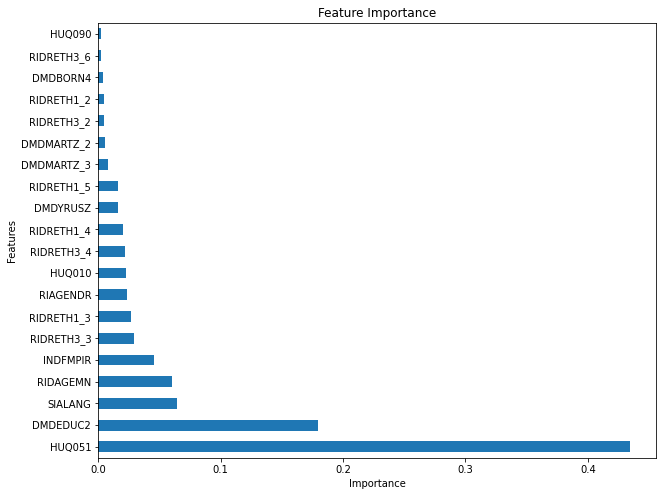

In [530]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### MLP

In [531]:
X, y = df[df.columns[df.columns != target_col]], df[target_col]

In [532]:
X[demo_cols + huq_cols] = MinMaxScaler().fit_transform(X[demo_cols + huq_cols])

In [533]:
df_l = pd.concat([X, y], axis = 1)

In [410]:
df_dum = pd.get_dummies(df_l[demo_cols + huq_cols + [target_col]], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols], drop_first = True)

In [411]:
X_train, X_test, y_train, y_test = train_test_split(df_dum[df_dum.columns[df_dum.columns != target_col]], 
                                                    df_dum[target_col], 
                                                    test_size=0.20
                                                    )

In [412]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [413]:
model = MLPClassifier()

In [414]:
grid_vals = {'hidden_layer_sizes': [(50,), (100,), (150)],
             'activation':['relu', 'identity', 'logistic', 'tanh'],
             'solver':['lbfgs', 'sgd', 'adam'],
             'alpha':[0.001, 0.01],
             'learning_rate':['constant', 'adaptive'],
             'max_iter':[200, 300],
             'early_stopping':[True, False]}

In [415]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [416]:
y_train = y_train.astype(int)

In [417]:
grid_lr.fit(X_train, y_train)

/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.

GridSearchCV(cv=3, error_score='raise', estimator=MLPClassifier(), n_jobs=4,
             param_grid={'activation': ['relu', 'identity', 'logistic', 'tanh'],
                         'alpha': [0.001, 0.01],
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(50,), (100,), 150],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             return_train_score=True, scoring='f1_micro')

In [418]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.075832      0.020282         0.003452        0.000233   
1         0.203896      0.007101         0.003591        0.000155   
2         0.493198      0.252418         0.003387        0.000183   
3         1.611652      0.044823         0.003963        0.000961   
4         0.198494      0.006754         0.003691        0.000114   
..             ...           ...              ...             ...   
571       7.559221      0.456861         0.013905        0.000692   
572       2.865518      0.717104         0.013550        0.000443   
573      10.625442      0.224364         0.013825        0.000534   
574       8.218778      1.318094         0.010499        0.002666   
575       3.311979      1.827368         0.011633        0.002699   

    param_activation param_alpha param_early_stopping  \
0               relu       0.001                 True   
1               relu       0.001                 True   
2               relu       0.001                 True   
3               relu       0.001                 True   
4               relu       0.001                 True   
..               ...         ...                  ...   
571             tanh        0.01                False   
572             tanh        0.01                False   
573             tanh        0.01                False   
574             tanh        0.01                False   
575             tanh        0.01                False   

    param_hidden_layer_sizes param_learning_rate param_max_iter param_solver  \
0                      (50,)            constant            200        lbfgs   
1                      (50,)            constant            200          sgd   
2                      (50,)            constant            200         adam   
3                      (50,)            constant            300        lbfgs   
4                      (50,)            constant            300          sgd   
..                       ...                 ...            ...          ...   
571                      150            adaptive            200          sgd   
572                      150            adaptive            200         adam   
573                      150            adaptive            300        lbfgs   
574                      150            adaptive            300          sgd   
575                      150            adaptive            300         adam   

                                                params  split0_test_score  \
0    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.889472   
1    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.883221   
2    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.891973   
3    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.882471   
4    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.882721   
..                                                 ...                ...   
571  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.894724   
572  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.892973   
573  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.869217   
574  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.894474   
575  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.893973   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.876219           0.880970         0.882221        0.005482   
1             0.883221           0.882971         0.883137        0.000118   
2             0.890473           0.891973         0.891473        0.000707   
3             0.878970           0.877469         0.879637        0.002095   
4             0.883221           0.882971         0.882971        0.000204   
..                 ...                ...              ...             ...   
571           0.887472           0.893473         0.891890 

In [419]:
grid_lr.best_estimator_

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50,),
              learning_rate='adaptive')

In [420]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

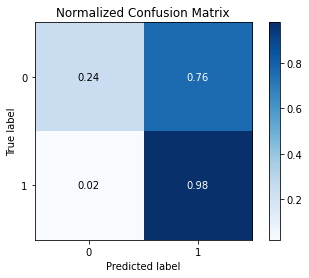

In [421]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [422]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.58      0.24      0.34       353
         Yes       0.91      0.98      0.94      2647

    accuracy                           0.89      3000
   macro avg       0.74      0.61      0.64      3000
weighted avg       0.87      0.89      0.87      3000



In [423]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

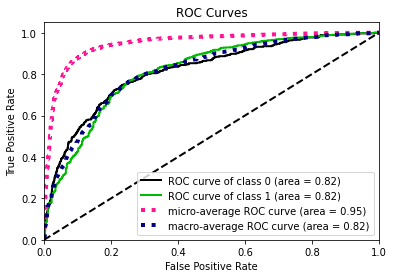

In [424]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [425]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.880846, G-mean=0.758


In [426]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

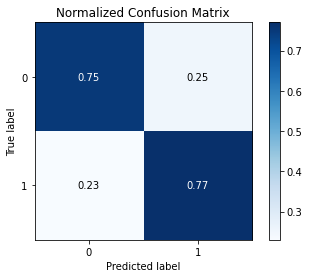

In [427]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [428]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.30      0.75      0.43       353
         Yes       0.96      0.77      0.85      2647

    accuracy                           0.77      3000
   macro avg       0.63      0.76      0.64      3000
weighted avg       0.88      0.77      0.80      3000



### CatBoost

In [429]:
df[demo_cols + huq_cols + [target_col]]

RIAGENDR  RIDAGEMN  RIDRETH1  RIDRETH3  DMDBORN4  DMDMARTZ  RIDEXPRG  \
0             0        24         5         6         0         4         4   
1             1       156         1         1         0         4         4   
2             0        24         3         3         0         4         4   
3             1       348         5         6         1         3         2   
4             1       252         2         2         1         3         3   
...         ...       ...       ...       ...       ...       ...       ...   
15393         0       480         4         4         0         1         4   
15394         0        24         4         4         0         4         4   
15395         1        84         3         3         0         4         4   
15396         0       756         4         4         0         2         4   
15397         0       888         2         2         1         1         4   

       SIALANG  SIAPROXY  SIAINTRP  DMDYRUSZ  DMDEDUC2  INDFMPIR  HUQ010  \
0            0         1         0         5         6      4.66       1   
1            0         1         0         5         6      0.83       2   
2            0         1         0         5         6      3.06       1   
3            0         0         0         2         5      5.00       3   
4            0         0         0         3         4      5.00       1   
...        ...       ...       ...       ...       ...       ...     ...   
15393        0         0         0         5         5      3.82       2   
15394        0         1         0         5         6      0.07       3   
15395        0         1         0         5         6      1.22       1   
15396        0         0         0         5         2      3.71       3   
15397        1         0         0         4         3      0.82       3   

       HUQ071  HUQ090  HUQ051  HIQ011  
0           0       0       1       1  
1           0       1       0       1  
2           0       0       2       1  
3           0       0       1       1  
4           0       0       1       1  
...       ...     ...     ...     ...  
15393       0       0       1       1  
15394       0       0       5       1  
15395       0       0       2       1  
15396       0       0       2       0  
15397       0       0       1       1  

[14997 rows x 18 columns]

In [534]:
X_train, X_test, y_train, y_test = train_test_split(df[demo_cols + huq_cols], 
                                                    df[target_col], 
                                                    test_size=0.20
                                                    )

In [535]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [536]:
y_train = y_train.astype(int)

In [537]:
sm = SMOTE()

In [538]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [539]:
model = CatBoostClassifier()

In [540]:
grid_vals = {'learning_rate': [0.01, 0.1], 'iterations': [50, 100, 150],
             'loss_function': ['Logloss', 'CrossEntropy'],
#                'num_leaves': [6, 12, 16], 
#                'colsample_bylevel': [0.75, 0.8], 
             'logging_level':['Silent'],
#                'subsample': [0.7, 0.8], 
             'l2_leaf_reg': [1e-5, 1e-2],
            'depth'         : [4,5,6],
#             "classes_count":[3]
            }


In [541]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=-1) 

In [542]:
# create categorical feature indices for catboost
cat_features = []

for col in demo_cols + huq_cols:
    
    if col == target_col:
        continue
        
    if col in nominal_cols + ordinal_cols:
        cat_features.append(X_train.columns.get_loc(col))
    

In [543]:
for col in X_train:
    X_train[col] = X_train[col].astype(int)

In [544]:
grid_lr.fit(X_train, y_train, cat_features=cat_features)

GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd4334495b0>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6], 'iterations': [50, 100, 150],
                         'l2_leaf_reg': [1e-05, 0.01],
                         'learning_rate': [0.01, 0.1],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             return_train_score=True, scoring='f1_micro')

In [545]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth  \
0        4.365269      0.573587         0.174049        0.115445           4   
1        4.294147      0.144866         0.378841        0.074523           4   
2        4.002116      0.911962         0.530962        0.168760           4   
3        4.169914      0.381518         0.291522        0.085489           4   
4        3.954312      0.067084         0.318147        0.099334           4   
5        4.778454      1.023264         0.404071        0.116909           4   
6        4.801968      0.254964         0.515127        0.153366           4   
7        5.578899      0.710480         0.269707        0.112410           4   
8       10.879645      0.325814         0.461669        0.154913           4   
9        8.289073      1.588341         0.371965        0.072313           4   
10       9.625528      0.463365         0.320197        0.116546           4   
11       7.809673      1.270169         0.345004        0.065222           4   
12       7.968772      0.215482         0.409700        0.097965           4   
13      10.313281      0.591927         0.408762        0.043045           4   
14       8.632127      0.916929         0.269743        0.132432           4   
15       9.061796      0.898214         0.410316        0.101002           4   
16      13.177214      0.441023         0.308689        0.058907           4   
17      12.787216      0.546448         0.325524        0.131195           4   
18      14.039799      1.092676         0.563897        0.108821           4   
19      12.104755      0.570355         0.321412        0.102782           4   
20      12.279702      0.310595         0.493397        0.168014           4   
21      12.256078      0.432152         0.348336        0.137210           4   
22      12.570808      0.635999         0.255524        0.083936           4   
23      14.277426      0.409134         0.433169        0.094998           4   
24       5.619766      0.173767         0.377002        0.141342           5   
25       6.112613      1.113630         0.298877        0.126608           5   
26       4.791411      0.859811         0.369769        0.083180           5   
27       5.079881      0.620364         0.367562        0.149408           5   
28       5.381907      0.348615         0.271497        0.046709           5   
29       5.579940      0.509639         0.437771        0.105017           5   
30       6.039268      0.680203         0.442009        0.115290           5   
31       6.128383      0.469653         0.228507        0.105278           5   
32       9.253303      0.700030         0.226198        0.059280           5   
33      10.857969      1.439643         0.355559        0.176934           5   
34      11.941666      0.031640         0.258258        0.052113           5   
35      10.317627      0.655130         0.406669        0.130575           5   
36      11.087657      0.660840         0.424757        0.227865           5   
37      10.357199      1.028579         0.429187        0.189896           5   
38      10.551061      0.790666         0.311170        0.100279           5   
39       9.651000      0.905137         0.399422        0.058239           5   
40      15.388790      0.783422         0.423766        0.139816           5   
41      15.940782      0.769074         0.470613        0.256226           5   
42      16.000554      1.170901         0.367935        0.118942           5   
43      15.871789      1.667859         0.419477        0.051793           5   
44      15.265948      0.895344         0.332252        0.051626           5   
45      16.000727      1.835829         0.249702        0.075134           5   
46      15.316785      1.011024         0.309560        0.048934           5   
47      16.541737      1.280680         0.347558        0.038555           5   
48       5.986537      1.668733         0.514631        0.129951           6   
49  

In [546]:
grid_lr.best_estimator_

In [547]:
y_pred = grid_lr.predict(X_test.astype(int))
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

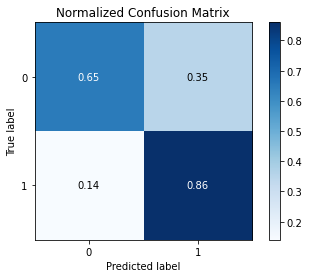

In [548]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [549]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.38      0.65      0.48       336
         Yes       0.95      0.86      0.91      2664

    accuracy                           0.84      3000
   macro avg       0.66      0.76      0.69      3000
weighted avg       0.89      0.84      0.86      3000



In [550]:
y_pred = grid_lr.predict_proba(X_test.astype(int))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

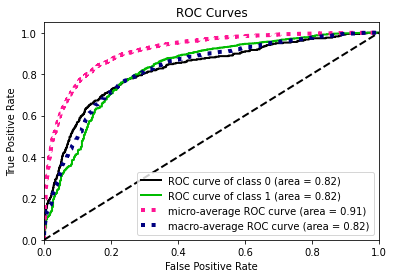

In [551]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [552]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.678160, G-mean=0.765


In [553]:
y_pred = np.where(y_pred[:,1] >= thresholds[ix],1,0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

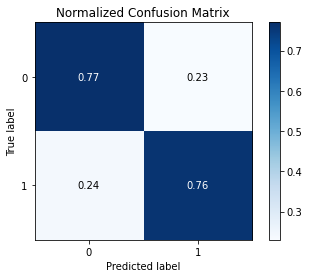

In [554]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), y_pred.tolist(), normalize=True)

In [555]:
print(classification_report(out["y_label"].tolist(), y_pred.tolist(), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.29      0.77      0.42       336
         Yes       0.96      0.76      0.85      2664

    accuracy                           0.76      3000
   macro avg       0.63      0.77      0.63      3000
weighted avg       0.89      0.76      0.80      3000



Text(0, 0.5, 'Features')

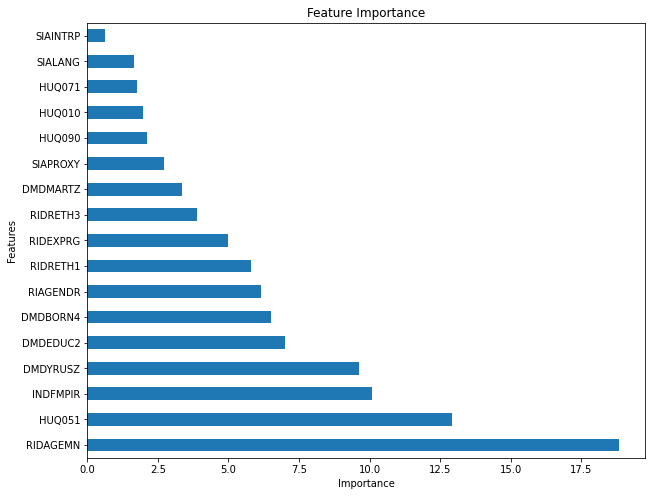

In [556]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")